In [ ]:
#| hide
!pip install -Uqq nixtla datasetsforecast

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# What if? Forecasting price effects in retail

You can use TimeGPT to forecast a set of timeseries, for example the demand of a product in retail. But what if you want to evaluate different pricing scenarios for that product? Performing such a scenario analysis can help you better understand how pricing affects product demand and can aid in decision making.

In this example, we will show you:
* How you can use TimeGPT to forecast product demand using price as an exogenous variable
* How you can evaluate different pricing scenarios that affect product demand

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/use-cases/5_what_if_pricing_scenarios_in_retail')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/use-cases/5_what_if_pricing_scenarios_in_retail.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
import os

from nixtla import NixtlaClient
from datasetsforecast.m5 import M5

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load M5 data

Let's see an example on predicting sales of products of the [M5 dataset](https://nixtlaverse.nixtla.io/datasetsforecast/m5.html). The M5 dataset contains daily product demand (sales) for 10 retail stores in the US.\
\
First, we load the data using `datasetsforecast`. This returns:

* `Y_df`, containing the sales (`y` column), for each unique product (`unique_id` column) at every timestamp (`ds` column). 
* `X_df`, containing additional relevant information for each unique product (`unique_id` column) at every timestamp (`ds` column). 

::: {.callout-tip}
You can find a tutorial on including exogenous variables in your forecast with TimeGPT [here](/docs/tutorials-timegpt_quickstart).
::: 

In [ ]:
#| eval: false
Y_df, X_df, S_df = M5.load(directory=os.getcwd())

Y_df.head(10)

100%|██████████| 50.2M/50.2M [00:00<00:00, 58.1MiB/s]
INFO:datasetsforecast.utils:Successfully downloaded m5.zip, 50219189, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed c:\Users\ospra\OneDrive\Nixtla\Repositories\nixtla\m5\datasets\m5.zip
c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\datasetsforecast\m5.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  keep_mask = long.groupby('id')['y'].transform(first_nz_mask, engine='numba')


,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0
5,FOODS_1_001_CA_1,2011-02-03,2.0
6,FOODS_1_001_CA_1,2011-02-04,0.0
7,FOODS_1_001_CA_1,2011-02-05,2.0
8,FOODS_1_001_CA_1,2011-02-06,0.0
9,FOODS_1_001_CA_1,2011-02-07,0.0


For this example, we will only keep the additional relevant information from the column `sell_price`. This column shows the selling price of the product, and we expect demand to fluctuate given a different selling price.

In [ ]:
#| eval: false
X_df = X_df[['unique_id', 'ds', 'sell_price']]

X_df.head(10)

,unique_id,ds,sell_price
0,FOODS_1_001_CA_1,2011-01-29,2.0
1,FOODS_1_001_CA_1,2011-01-30,2.0
2,FOODS_1_001_CA_1,2011-01-31,2.0
3,FOODS_1_001_CA_1,2011-02-01,2.0
4,FOODS_1_001_CA_1,2011-02-02,2.0
5,FOODS_1_001_CA_1,2011-02-03,2.0
6,FOODS_1_001_CA_1,2011-02-04,2.0
7,FOODS_1_001_CA_1,2011-02-05,2.0
8,FOODS_1_001_CA_1,2011-02-06,2.0
9,FOODS_1_001_CA_1,2011-02-07,2.0


## 3. Forecasting demand using price as an exogenous variable

We will forecast the demand for a single product only, for all 10 retail stores in the dataset. We choose a food product with many price changes identified by `FOODS_1_129_`.

In [ ]:
#| eval: false
products = [
            'FOODS_1_129_CA_1', 
            'FOODS_1_129_CA_2', 
            'FOODS_1_129_CA_3', 
            'FOODS_1_129_CA_4', 
            'FOODS_1_129_TX_1', 
            'FOODS_1_129_TX_2', 
            'FOODS_1_129_TX_3',
            'FOODS_1_129_WI_1',
            'FOODS_1_129_WI_2',
            'FOODS_1_129_WI_3'
            ]
Y_df_product = Y_df.query('unique_id in @products')
X_df_product = X_df.query('unique_id in @products')

We merge our two dataframes to create the dataset to be used in TimeGPT.

In [ ]:
#| eval: false
df = Y_df_product.merge(X_df_product)

df.head(10)

,unique_id,ds,y,sell_price
0,FOODS_1_129_CA_1,2011-02-01,1.0,6.22
1,FOODS_1_129_CA_1,2011-02-02,0.0,6.22
2,FOODS_1_129_CA_1,2011-02-03,0.0,6.22
3,FOODS_1_129_CA_1,2011-02-04,0.0,6.22
4,FOODS_1_129_CA_1,2011-02-05,1.0,6.22
5,FOODS_1_129_CA_1,2011-02-06,0.0,6.22
6,FOODS_1_129_CA_1,2011-02-07,0.0,6.22
7,FOODS_1_129_CA_1,2011-02-08,0.0,6.22
8,FOODS_1_129_CA_1,2011-02-09,0.0,6.22
9,FOODS_1_129_CA_1,2011-02-10,3.0,6.22


In [ ]:
#| hide
if not IN_COLAB:
    df = pd.read_parquet("../../assets/M5_what_if_pricing_example.parquet")
    products = list(df["unique_id"].unique())

Let's investigate how the demand - our target `y` - of these products has evolved in the last year of data. We see that in the California stores (with a `CA_` suffix), the product has sold intermittently, whereas in the other regions (`TX` and `WY`) sales where less intermittent. Note that the plot only shows 8 (out of 10) stores.

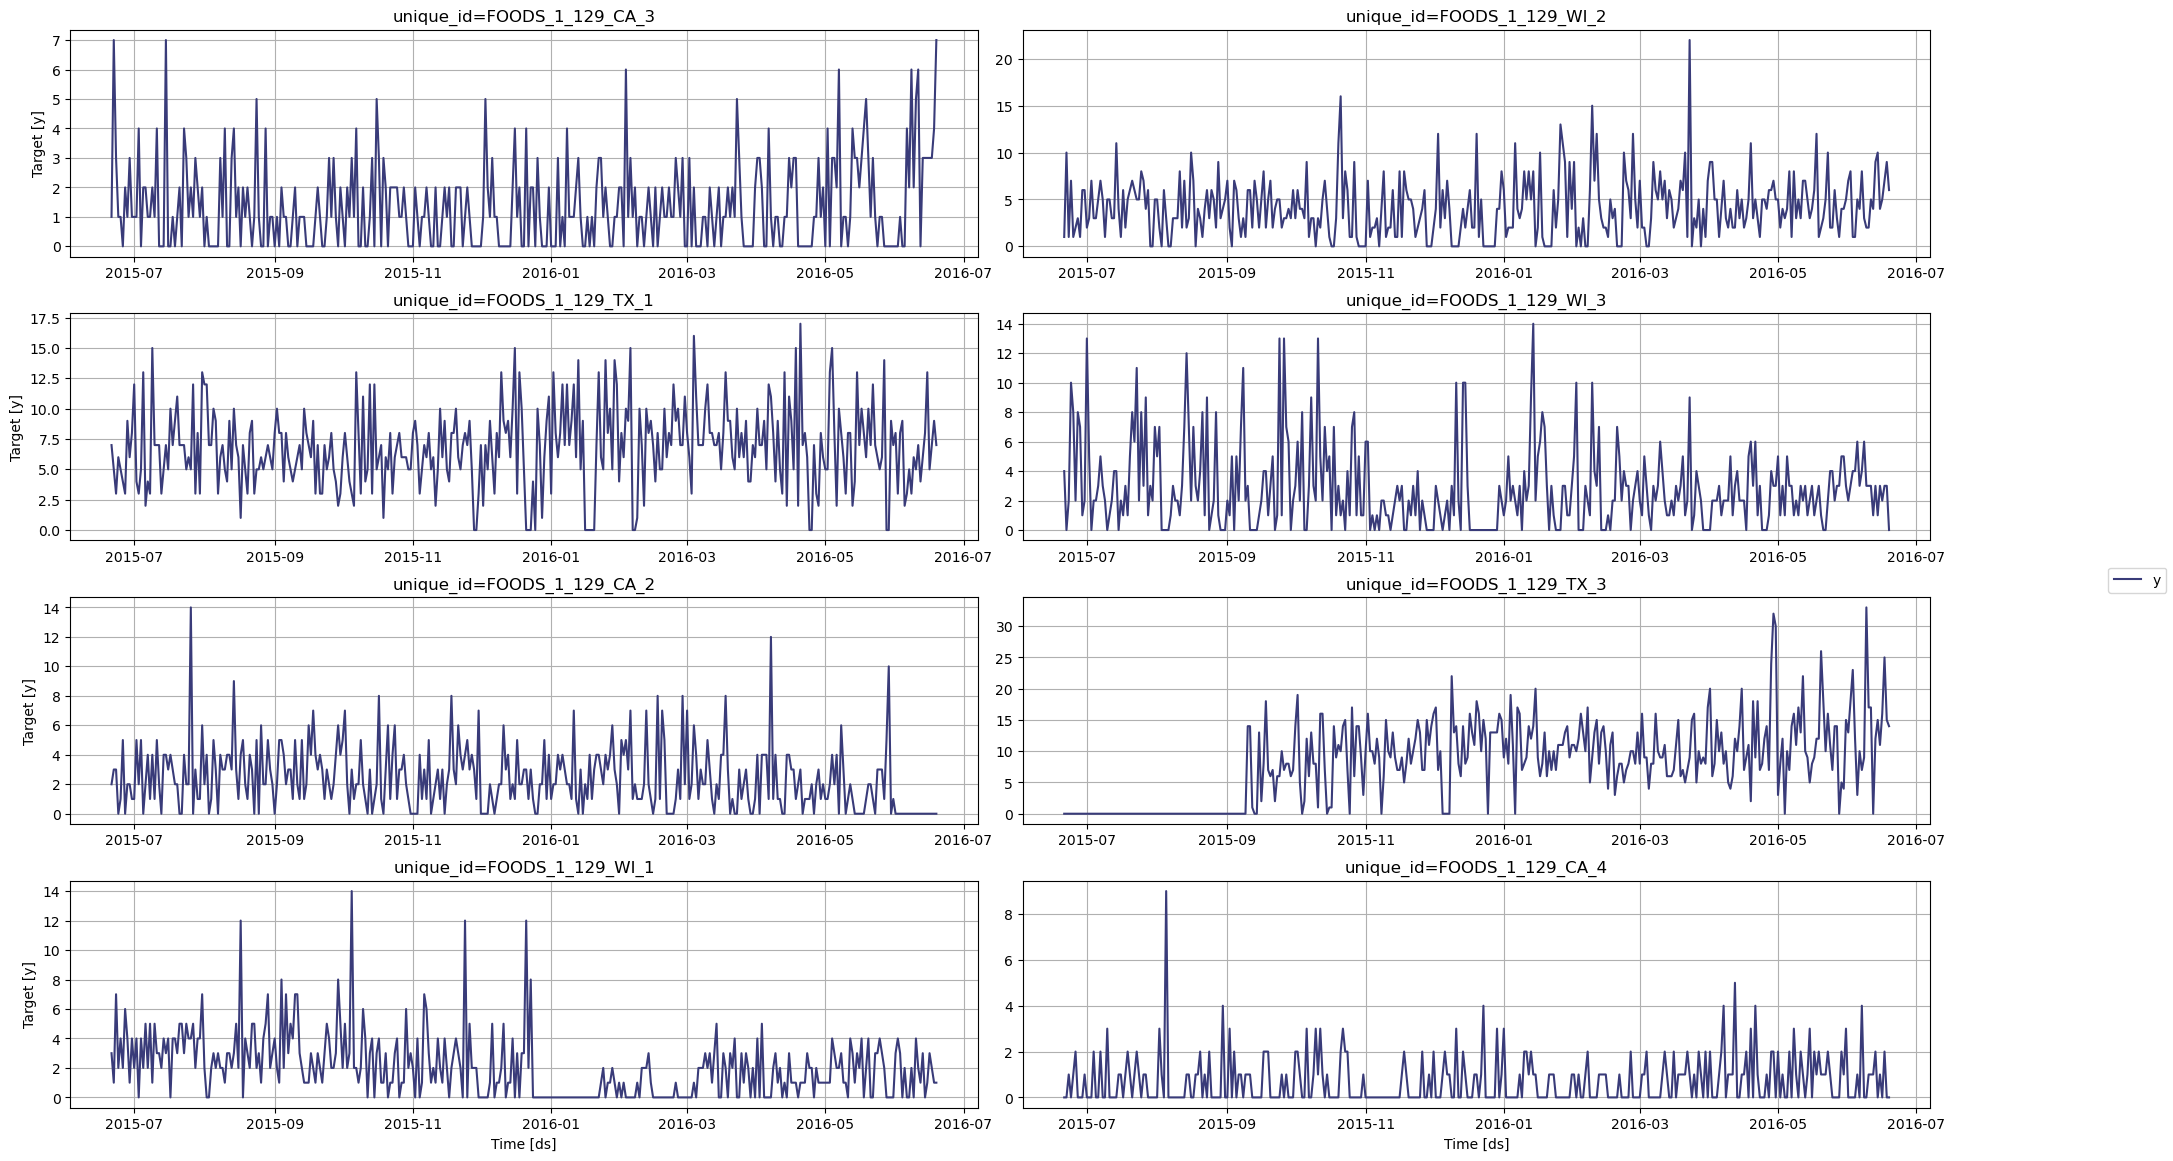

In [ ]:
nixtla_client.plot(df, 
                   unique_ids=products,
                   max_insample_length=365)

Next, we look at the `sell_price` of these products across the entire data available. We find that there have been relatively few price changes - about 20 in total - over the period 2011 - 2016. Note that the plot only shows 8 (out of 10) stores.

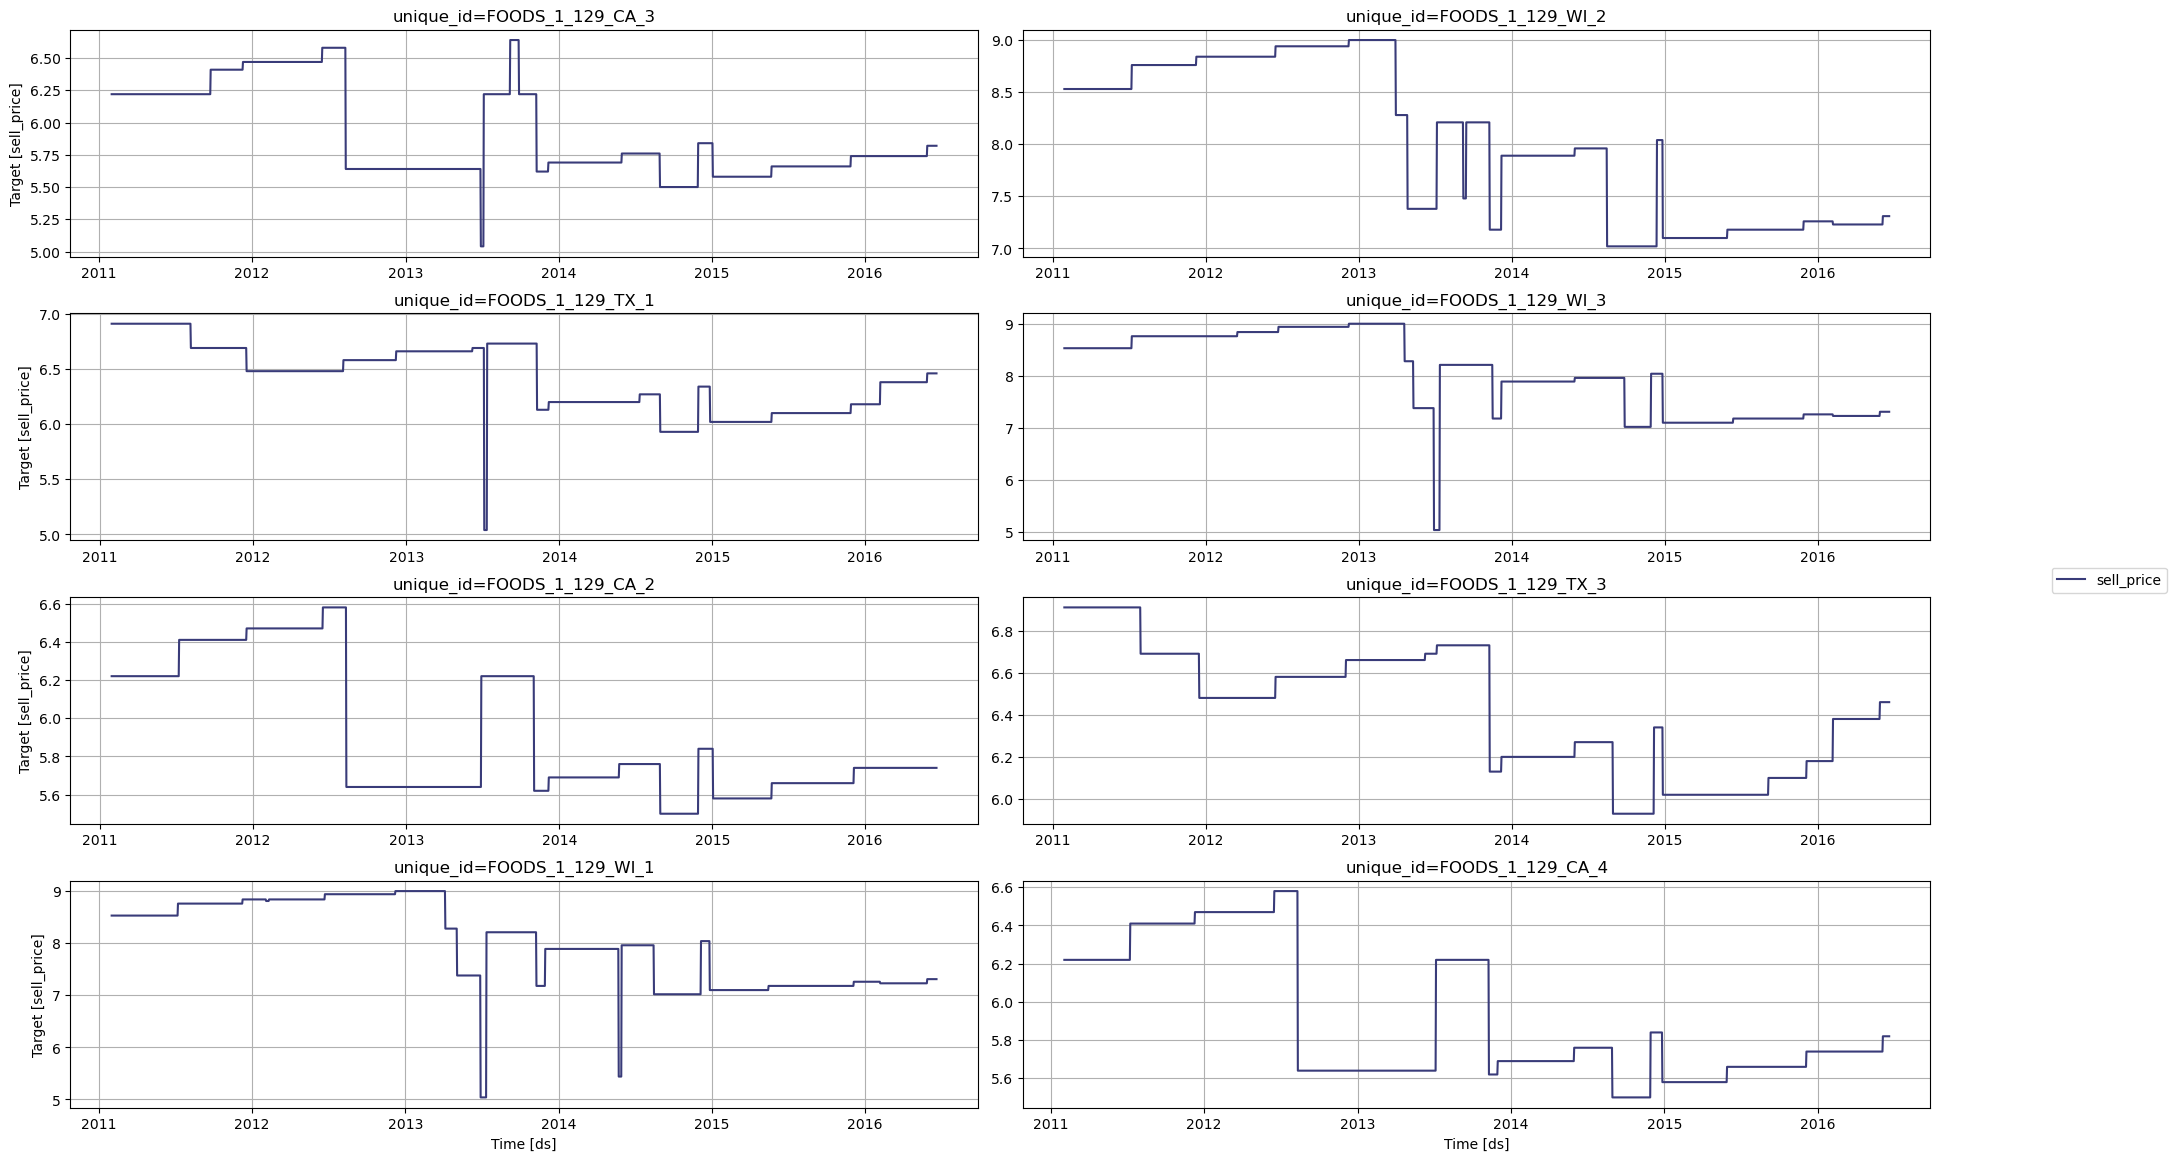

In [ ]:
nixtla_client.plot(df, 
                   unique_ids=products,
                   target_col='sell_price')

Let's turn to our forecasting task. We will forecast the last 28 days in the dataset. 

To use the `sell_price` exogenous variable in TimeGPT, we have to add it as future values. Therefore, we create a future values dataframe, that contains the `unique_id`, the timestamp `ds`, and `sell_price`.

In [ ]:
future_ex_vars_df = df.drop(columns = ['y'])
future_ex_vars_df = future_ex_vars_df.query("ds >= '2016-05-23'")

future_ex_vars_df.head(10)

,unique_id,ds,sell_price
1938,FOODS_1_129_CA_1,2016-05-23,5.74
1939,FOODS_1_129_CA_1,2016-05-24,5.74
1940,FOODS_1_129_CA_1,2016-05-25,5.74
1941,FOODS_1_129_CA_1,2016-05-26,5.74
1942,FOODS_1_129_CA_1,2016-05-27,5.74
1943,FOODS_1_129_CA_1,2016-05-28,5.74
1944,FOODS_1_129_CA_1,2016-05-29,5.74
1945,FOODS_1_129_CA_1,2016-05-30,5.74
1946,FOODS_1_129_CA_1,2016-05-31,5.74
1947,FOODS_1_129_CA_1,2016-06-01,5.74


Next, we limit our input dataframe to all but the 28 forecast days:

In [ ]:
df_train = df.query("ds < '2016-05-23'")

df_train.tail(10)

,unique_id,ds,y,sell_price
19640,FOODS_1_129_WI_3,2016-05-13,3.0,7.23
19641,FOODS_1_129_WI_3,2016-05-14,1.0,7.23
19642,FOODS_1_129_WI_3,2016-05-15,2.0,7.23
19643,FOODS_1_129_WI_3,2016-05-16,3.0,7.23
19644,FOODS_1_129_WI_3,2016-05-17,1.0,7.23
19645,FOODS_1_129_WI_3,2016-05-18,2.0,7.23
19646,FOODS_1_129_WI_3,2016-05-19,3.0,7.23
19647,FOODS_1_129_WI_3,2016-05-20,1.0,7.23
19648,FOODS_1_129_WI_3,2016-05-21,0.0,7.23
19649,FOODS_1_129_WI_3,2016-05-22,0.0,7.23


Let's call the `forecast` method of TimeGPT:

In [ ]:
timegpt_fcst_df = nixtla_client.forecast(df=df_train, X_df=future_ex_vars_df, h=28)
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Using the following exogenous variables: sell_price
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT
0,FOODS_1_129_CA_1,2016-05-23,0.875594
1,FOODS_1_129_CA_1,2016-05-24,0.777731
2,FOODS_1_129_CA_1,2016-05-25,0.786871
3,FOODS_1_129_CA_1,2016-05-26,0.828223
4,FOODS_1_129_CA_1,2016-05-27,0.791228


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

We plot the forecast, the actuals and the last 28 days before the forecast period:

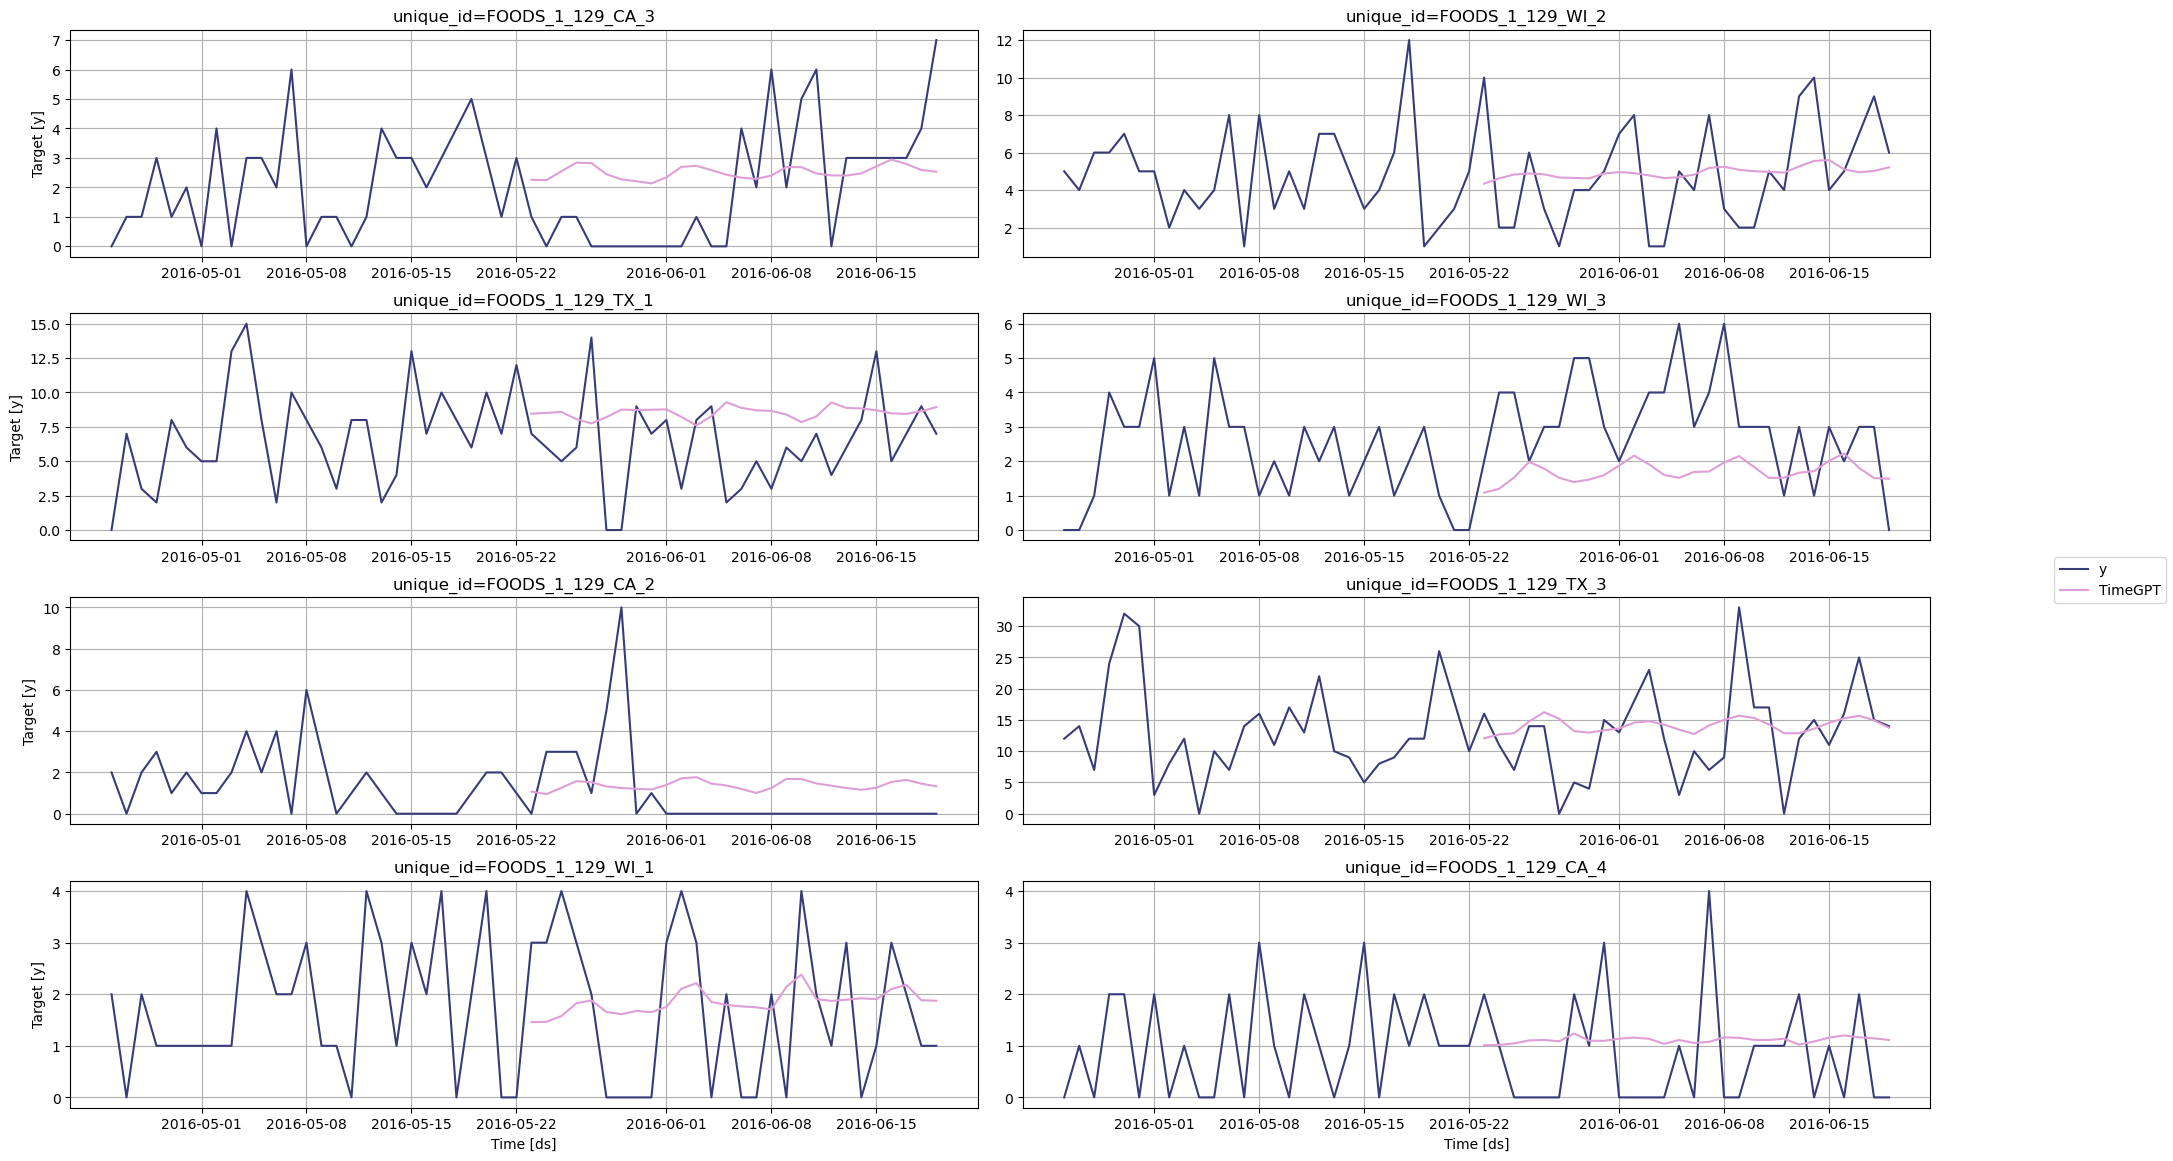

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    timegpt_fcst_df, 
    max_insample_length=56, 
)

## 4. What if? Varying price when forecasting demand

What happens when we change the price of the products in our forecast period? Let's see how our forecast changes when we increase and decrease the `sell_price` by 5%.

In [ ]:
price_change = 0.05

# Plus 
future_ex_vars_df_plus= future_ex_vars_df.copy()
future_ex_vars_df_plus["sell_price"] = future_ex_vars_df_plus["sell_price"] * (1 + price_change)
# Minus
future_ex_vars_df_minus = future_ex_vars_df.copy()
future_ex_vars_df_minus["sell_price"] = future_ex_vars_df_minus["sell_price"] * (1 - price_change)

Let's create a new set of forecasts with TimeGPT.

In [ ]:
timegpt_fcst_df_plus = nixtla_client.forecast(df=df_train, X_df=future_ex_vars_df_plus, h=28)
timegpt_fcst_df_minus = nixtla_client.forecast(df=df_train, X_df=future_ex_vars_df_minus, h=28)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Using the following exogenous variables: sell_price
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Using the following exogenous variables: sell_price
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

Let's combine our three forecasts. We see that - as we expect - demand is expected to slightly increase (decrease) if we reduce (increase) the price. In other words, a cheaper product leads to higher sales and vice versa. 

::: {.callout-note}
_Price elasticity_ is a measure of how sensitive the (product) demand is to a change in price. Read more about it [here](https://en.wikipedia.org/wiki/Price_elasticity_of_demand).
::: 

In [ ]:
timegpt_fcst_df_plus = timegpt_fcst_df_plus.rename(columns={'TimeGPT':f'TimeGPT-sell_price_plus_{price_change * 100:.0f}%'})
timegpt_fcst_df_minus = timegpt_fcst_df_minus.rename(columns={'TimeGPT':f'TimeGPT-sell_price_minus_{price_change * 100:.0f}%'})

timegpt_fcst_df = pd.concat([timegpt_fcst_df, 
                             timegpt_fcst_df_plus[f'TimeGPT-sell_price_plus_{price_change * 100:.0f}%'], 
                             timegpt_fcst_df_minus[f'TimeGPT-sell_price_minus_{price_change * 100:.0f}%']], axis=1)

timegpt_fcst_df.head(10)

,unique_id,ds,TimeGPT,TimeGPT-sell_price_plus_5%,TimeGPT-sell_price_minus_5%
0,FOODS_1_129_CA_1,2016-05-23,0.875594,0.847006,1.370029
1,FOODS_1_129_CA_1,2016-05-24,0.777731,0.749142,1.272166
2,FOODS_1_129_CA_1,2016-05-25,0.786871,0.758283,1.281306
3,FOODS_1_129_CA_1,2016-05-26,0.828223,0.799635,1.322658
4,FOODS_1_129_CA_1,2016-05-27,0.791228,0.762640,1.285663
5,FOODS_1_129_CA_1,2016-05-28,0.819133,0.790545,1.313568
6,FOODS_1_129_CA_1,2016-05-29,0.839992,0.811404,1.334427
7,FOODS_1_129_CA_1,2016-05-30,0.843070,0.814481,1.337505
8,FOODS_1_129_CA_1,2016-05-31,0.833089,0.804500,1.327524
9,FOODS_1_129_CA_1,2016-06-01,0.855032,0.826443,1.349467


Finally, let's plot the forecasts for our different pricing scenarios, showing how TimeGPT forecasts a different demand when the price of a set of products is changed. In the graphs we can see that for specific products for certain periods the discount increases expected demand, while during other periods and for other products, price change has a smaller effect on total demand. 

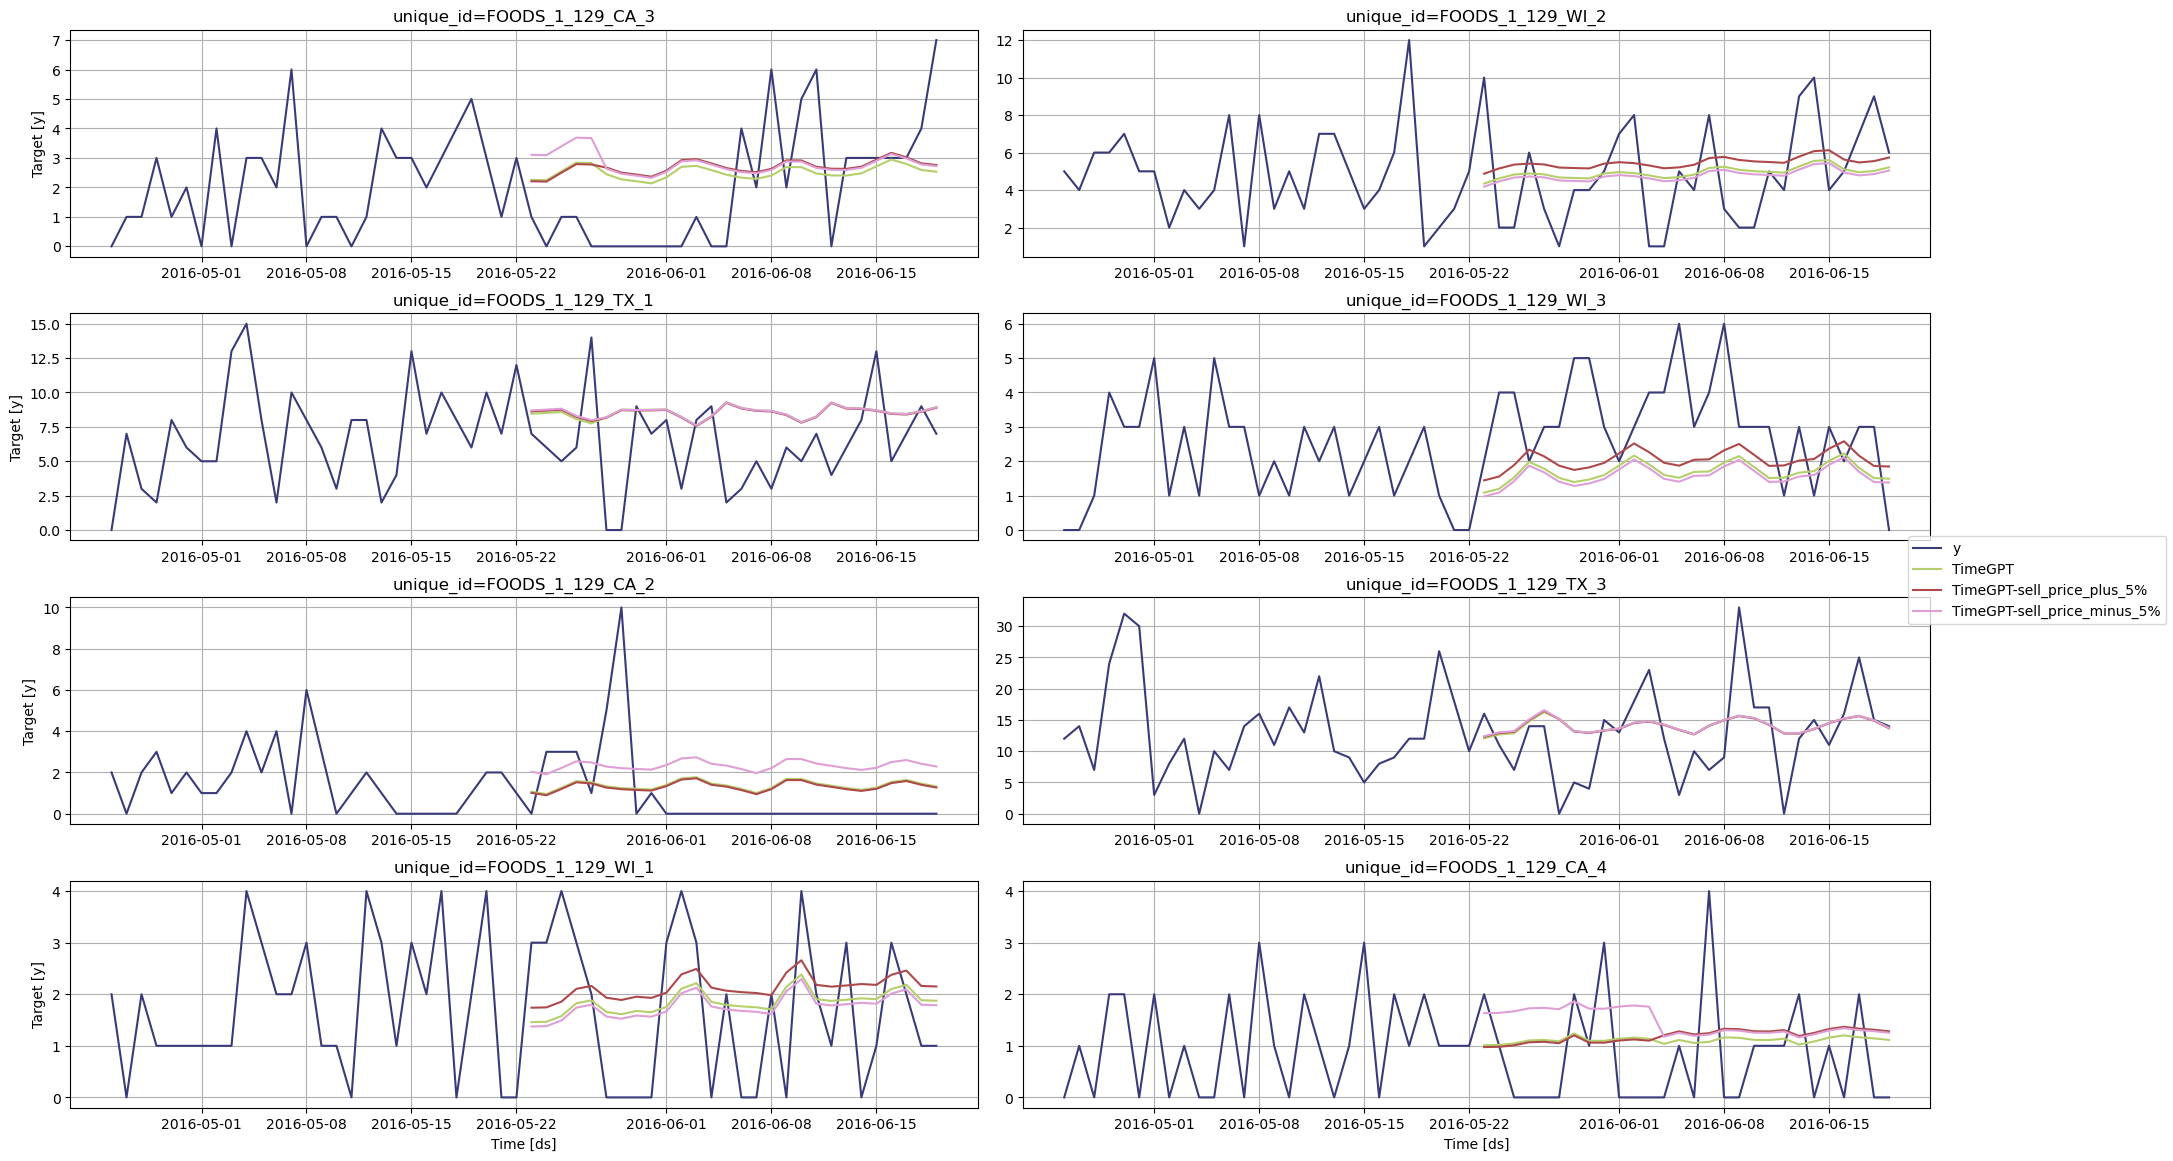

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    timegpt_fcst_df, 
    max_insample_length=56, 
)

In this example, we have shown you:
* How you can use TimeGPT to forecast product demand using price as an exogenous variable
* How you can evaluate different pricing scenarios that affect product demand

::: {.callout-important}
* This method assumes that historical demand and price behaviour is predictive of future demand, and omits other factors affecting demand. To include these other factors, use additional exogenous variables that provide the model with more context about the factors influencing demand.
* This method is sensitive to unmodelled events that affect the demand, such as sudden market shifts. To include those, use additional exogenous variables indicating such sudden shifts if they have been observed in the past too.
:::